# 5.1-2 DCGAN 작성

- DCGAN의 네트워크를 구현하고 학습합니다.


# 5.1 학습 목표

1.	Generator가 화상을 생성하기 위해 어떠한 신경망 구조를 하고 있는지 이해한다
2.	Discriminator가 화상을 식별하기 위해 어떤 신경망 구조를 하고 있는지 이해한다
3.	GAN의 일반적인 손실함수의 형태와 신경망의 학습 흐름을 이해한다
4.	DCGAN 네트워크를 구현할 수 있다


# 5.2 학습 목표

1.	GAN의 손실함수의 형태를 이해한다
2.	DCGAN을 구현하고, 필기체 숫자 화상을 생성할 수 있다


# 사전 준비
도서의 지시에 따라, 이 장에서 사용하는 데이터를 준비합니다

In [1]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# 전치 합성곱의 예

In [3]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("입력 데이터")
print(input)
print("-----")

print("일반 합성곱")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("커널")
print(m.weight)
print("출력")
print(m(input))

print("-----")
print("전치 합성곱")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("커널")
print(m.weight)
print("출력")
print(m(input))


입력 데이터
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
일반 합성곱
커널
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
출력
tensor([[[[17.]]]], grad_fn=<ThnnConv2DBackward>)
-----
전치 합성곱
커널
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
출력
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<ThnnConvTranspose2DBackward>)


# Generator 구현

In [4]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


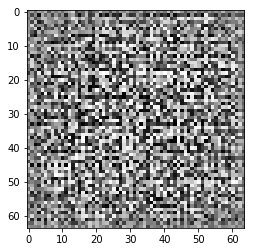

In [5]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기를 (1, 20, 1, 1)으로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminator 구현

In [6]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 입력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


In [7]:
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))


tensor([[[[0.4931]]]], grad_fn=<SigmoidBackward>)


# 6.2로


# GAN 손실 함수

In [8]:
# D의 오차함수의 이미지 구현
# maximize log(D(x)) + log(1 - D(G(z)))


# ※ x가 정의되지 않았으므로, 에러가 됩니다
#---------------


# 정답 라벨 작성
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 가짜 라벨 작성
label_fake = torch.full((mini_batch_size,), 0)

# 오차함수 정의
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 진짜 화상을 판정
d_out_real = D(x)

# 가짜 화상을 생성해 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake


NameError: name 'x' is not defined

In [9]:
# G의 오차함수의 이미지 구현
# maximize log(D(G(z)))


# ※ x가 정의되지 않았으므로, 에러가 됩니다
#---------------


# 가짜 화상을 생성해 판정
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 오차를 계산
g_loss = criterion(d_out_fake.view(-1), label_real)


# DataLoader 작성

In [10]:
def make_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [11]:
class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [12]:
class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed


In [13]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list=make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# 학습시킨다

In [14]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")


네트워크 초기화 완료


In [15]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 화상을 판정
            d_out_real = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D


In [ ]:
# 학습 및 검증을 실행한다
# 6분 정도 걸립니다
num_epochs = 200
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


사용 장치:  cuda:0
-------------
Epoch 0/200
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1154 ||Epoch_G_Loss:0.0765
timer:  2.6459 sec.
-------------
Epoch 1/200
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1300 ||Epoch_G_Loss:0.1361
timer:  1.4897 sec.
-------------
Epoch 2/200
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.0570 ||Epoch_G_Loss:0.1472
timer:  1.5022 sec.
-------------
Epoch 3/200
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.0114 ||Epoch_G_Loss:0.3051
timer:  1.5032 sec.
-------------
Epoch 4/200
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.1862 ||Epoch_G_Loss:0.2787
timer:  1.4950 sec.
-------------
Epoch 5/200
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.0170 ||Epoch_G_Loss:0.2853
timer:  1.5015 sec.
-------------
Epoch 6/200
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.1775 ||Epoch_G_Loss:0.1950
timer:  1.5046 sec.
-------------
Epoch 7/200
-------------


-------------
epoch 60 || Epoch_D_Loss:0.0816 ||Epoch_G_Loss:0.2015
timer:  1.5231 sec.
-------------
Epoch 61/200
-------------
(train)
-------------
epoch 61 || Epoch_D_Loss:0.0739 ||Epoch_G_Loss:0.1976
timer:  1.5256 sec.
-------------
Epoch 62/200
-------------
(train)
-------------
epoch 62 || Epoch_D_Loss:0.0757 ||Epoch_G_Loss:0.1933
timer:  1.5366 sec.
-------------
Epoch 63/200
-------------
(train)
-------------
epoch 63 || Epoch_D_Loss:0.0827 ||Epoch_G_Loss:0.1969
timer:  1.5331 sec.
-------------
Epoch 64/200
-------------
(train)
-------------
epoch 64 || Epoch_D_Loss:0.0875 ||Epoch_G_Loss:0.2031
timer:  1.5245 sec.
-------------
Epoch 65/200
-------------
(train)
-------------
epoch 65 || Epoch_D_Loss:0.0940 ||Epoch_G_Loss:0.2365
timer:  1.5271 sec.
-------------
Epoch 66/200
-------------
(train)
-------------
epoch 66 || Epoch_D_Loss:0.0820 ||Epoch_G_Loss:0.1746
timer:  1.5263 sec.
-------------
Epoch 67/200
-------------
(train)
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.2344
timer:  1.5560 sec.
-------------
Epoch 121/200
-------------
(train)
-------------
epoch 121 || Epoch_D_Loss:0.0636 ||Epoch_G_Loss:0.3001
timer:  1.5445 sec.
-------------
Epoch 122/200
-------------
(train)
-------------
epoch 122 || Epoch_D_Loss:0.0573 ||Epoch_G_Loss:0.2712
timer:  1.5426 sec.
-------------
Epoch 123/200
-------------
(train)
-------------
epoch 123 || Epoch_D_Loss:0.0645 ||Epoch_G_Loss:0.3071
timer:  1.5289 sec.
-------------
Epoch 124/200
-------------
(train)
-------------
epoch 124 || Epoch_D_Loss:0.0431 ||Epoch_G_Loss:0.2718
timer:  1.5403 sec.
-------------
Epoch 125/200
-------------
(train)
-------------
epoch 125 || Epoch_D_Loss:0.0863 ||Epoch_G_Loss:0.2736
timer:  1.5383 sec.
-------------
Epoch 126/200
-------------
(train)
-------------
epoch 126 || Epoch_D_Loss:0.0455 ||Epoch_G_Loss:0.3053
timer:  1.5537 sec.
-------------
Epoch 127/200
-------------
(train)
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0249 ||Epoch_G_Loss:0.4146
timer:  1.5375 sec.
-------------
Epoch 180/200
-------------
(train)
-------------
epoch 180 || Epoch_D_Loss:0.0480 ||Epoch_G_Loss:0.4015
timer:  1.5364 sec.
-------------
Epoch 181/200
-------------
(train)
-------------
epoch 181 || Epoch_D_Loss:0.0259 ||Epoch_G_Loss:0.4990
timer:  1.5421 sec.
-------------
Epoch 182/200
-------------
(train)
-------------
epoch 182 || Epoch_D_Loss:0.0129 ||Epoch_G_Loss:0.5540
timer:  1.5535 sec.
-------------
Epoch 183/200
-------------
(train)
-------------
epoch 183 || Epoch_D_Loss:0.0723 ||Epoch_G_Loss:0.2949
timer:  1.5466 sec.
-------------
Epoch 184/200
-------------
(train)
-------------
epoch 184 || Epoch_D_Loss:0.0142 ||Epoch_G_Loss:0.4174
timer:  1.5371 sec.
-------------
Epoch 185/200
-------------
(train)
-------------
epoch 185 || Epoch_D_Loss:0.0494 ||Epoch_G_Loss:0.4414
timer:  1.5362 sec.
-------------
Epoch 186/200
-------------
(train)
-------------
epoch 186 || 

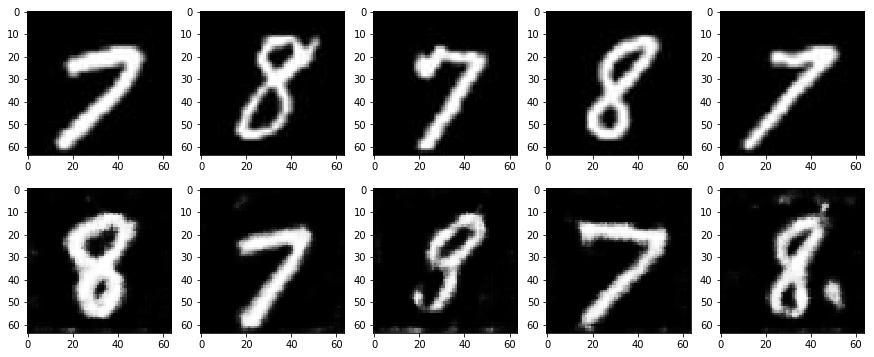

In [ ]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

끝